# Time-Evolution of Quantum Density Matrices in Conjugated Systems

## Case: Many-Level, Same Energy, with Dissipation

## Table of Contents

1. [Parameters](#1.-Parameters)

  - [Hamiltonian](#Hamiltonian)
  - [Initial Condition](#Initial-Condition)
  - [Numerical Solver](#Numerical-Solver)
  - [Plotting](#Plotting)

2. [Derived Parameters](#2.-Derived-Parameters)

3. [Tool Functions](#3.-Tool-Functions)

4. [Unperturbed Solution](#4.-Unperturbed-Solution)

  - [Molecular Orbitals](#Molecular-Orbitals)
  - [Mean Density](#Mean-Density)

5. [Full System Solution](#5.-Full-System-Solution)

6. [Plot](#6.-Plot)

  - [Consistency Check](#Consistency-Check)


In [1]:
%matplotlib notebook
from IPython.display import display
import numpy as np
import numpy.linalg as lg
from scipy.integrate import ode
import matplotlib.pyplot as plt

## 1. Parameters

### Hamiltonian

In [2]:
# Many-level system with dissipation matrix
#
#   dρ        i              1
#  ---- = - ----- [H, ρ] - ----- Γ
#   dt      h_bar          h_bar
#
#  where H = [a'  b'] = [a  b]  +  [a_em  b_em] sin(wt+φ)
#            [b'  a']   [b  a]     [b_em  a_em]
#
#
#  Use atomic unit where h_bar = 1
#

def tri(A, B, N):
    """ Non-sparse tridiagonal square matrix constructor
    Args:
        A: diagonal term
        B: off-diagonal term
        N: dimension
    """
    return np.matrix(B * np.eye(N, N, k=-1) + \
                     A * np.eye(N, N) + \
                     B * np.eye(N, N, k=1))

# Number of Levels
N_H = 20

# Unperturbed Hamiltonian
A = -0.2  # typical alpha = -27.2eV * 0.2 = -5.44eV (unimportant now...)
#dA = 0.0  # energy raise at the final atom
B = -0.1  # typical beta = -27.2eV * 0.1 = -2.72 eV
H0 = tri(A, B, N_H)

# Electromagnetic Hamiltonian
A_em = 0.0  # Non-polar molecule = 0
B_em = -0.05  # dipole interaction 
H_em = tri(A_em, B_em, N_H)

w_em = 0.2
  # Typical Angular Freq. of Absorption Spectrum: 
  #   UV-Vis: 400nm -> T = 1.334fs = 55.1 (a.u.)
  #                    w_em = 2*pi/T = 0.114
  #   IR: 1600 cm-1 -> T = 20.85fs = 868.75 (a.u.)
  #                    w_em = 2*pi/T = 7.2e-3 (too slow)
  
psi0_em = 0.0  # initial phase angle

# Dissipation Term
Gamma = 0.05
#Gamma = 0.0

### Initial Condition

In [3]:
# time
ti = 0.0

# state ( rho0 = |phi0> <phi0| / norm(|phi0><phi0|) )
phi0_unnormalized = np.zeros([N_H, 1])
phi0_unnormalized[0] = 1

### Numerical Solver

In [4]:
integration_method = "zvode"  # Adams-Bashforth-based, 4th order.

### Plotting

In [5]:
# tf
n_scale = 20
t_scale = (2 * np.pi) / (2 * abs(B))   # only an reasonable estimate
tf = n_scale * t_scale

# points to plot, including both endpoints
pts = 1 + 30000

## 2. Derived Parameters

### Main Equation

In [6]:
# I.C.
phi0 = phi0_unnormalized / lg.norm(phi0_unnormalized)
rho0 = np.tensordot(phi0, phi0, axes=0)
rho0_vec = rho0.reshape(N_H*N_H, )
assert rho0_vec.shape == (N_H*N_H, )

# points to plot
t_lin = np.linspace(ti, tf, pts)
assert np.size(t_lin) == pts

# step length
dt_lin = t_lin[1:pts] - t_lin[0:pts-1]  # (1 ~ pts-1) - (0 ~ pts-2)
assert np.size(dt_lin) == pts - 1

# main equation
def f_rhodot_vec(t, rho_vec, N_H, H0, H_em, w_em, psi0_em, Gamma, rho0_un_mean):

    # reshape to matrix before calculation
    rho = rho_vec.reshape(N_H, N_H)
    
    # calculate commutator
    H = H0 + np.sin(w_em*t + psi0_em) * H_em
    rhodot =  (-1j) * (np.dot(H, rho) - np.dot(rho, H)) - Gamma * (rho - rho0_un_mean)

    # cast to vector
    return rhodot.reshape(N_H*N_H, )

### Unperturbed Equation

In [7]:
def f_rhodot_un_vec(t, rho_vec, N_H, H0):

    # reshape to matrix before calculation
    rho = rho_vec.reshape(N_H, N_H)
    
    # calculate commutator
    rhodot =  (-1j) * (np.dot(H0, rho) - np.dot(rho, H0))

    # cast to vector
    return rhodot.reshape(N_H*N_H, )

## 3. Tool Functions

In [8]:
# convert rho_vec[i] to rho[m,n]
def i_to_mn(i):
    m = np.floor(i / N_H) 
    n = np.floor(i % N_H)
    return int(m), int(n)

assert i_to_mn(N_H) == (1, 0)

# convert rho[m,n] to rho_vec[i]
def mn_to_i(m, n):
    return m * N_H + n

assert mn_to_i(1, 0) == N_H

## 4. Unperturbed Solution

### Molecular Orbitals

In [9]:
# Diagonalized Solution
e0, MO0 = lg.eigh(H0)

In [10]:
np.around(e0, 4)

array([-0.3978, -0.3911, -0.3802, -0.3652, -0.3466, -0.3247, -0.3   ,
       -0.2731, -0.2445, -0.2149, -0.1851, -0.1555, -0.1269, -0.1   ,
       -0.0753, -0.0534, -0.0348, -0.0198, -0.0089, -0.0022])

In [11]:
# Lowest MO 
display("Lowest MO:")
display(MO0[:, 0])
# check sign (all the same)
assert np.all(MO0[:, 0] >= 0) if MO0[0, 0] > 0 else np.all(MO0[:, 0] <= 0)
# check symmetry
assert MO0[0, 0] - MO0[N_H-1, 0] < 1e-13

# Highest MO
display("Highest MO:")
display(MO0[:, N_H-1])
# check sign (interchanging)
if MO0[0, N_H-1] > 0:
    for i in range(int(N_H / 2)):
        assert MO0[i*2, N_H-1] > 0
        assert MO0[i*2 + 1, N_H-1] < 0
else:
    for i in range(int(N_H / 2)):
        assert MO0[i*2, N_H-1] < 0
        assert MO0[i*2 + 1, N_H-1] > 0
# check symmetry
assert abs(MO0[0, N_H-1]) - abs(MO0[N_H-1, N_H-1]) < 1e-13


'Lowest MO:'

matrix([[-0.04599544],
        [-0.09096342],
        [-0.13389943],
        [-0.17384434],
        [-0.20990586],
        [-0.24127843],
        [-0.26726124],
        [-0.28727388],
        [-0.30086929],
        [-0.30774377],
        [-0.30774377],
        [-0.30086929],
        [-0.28727388],
        [-0.26726124],
        [-0.24127843],
        [-0.20990586],
        [-0.17384434],
        [-0.13389943],
        [-0.09096342],
        [-0.04599544]])

'Highest MO:'

matrix([[ 0.04599544],
        [-0.09096342],
        [ 0.13389943],
        [-0.17384434],
        [ 0.20990586],
        [-0.24127843],
        [ 0.26726124],
        [-0.28727388],
        [ 0.30086929],
        [-0.30774377],
        [ 0.30774377],
        [-0.30086929],
        [ 0.28727388],
        [-0.26726124],
        [ 0.24127843],
        [-0.20990586],
        [ 0.17384434],
        [-0.13389943],
        [ 0.09096342],
        [-0.04599544]])

### Mean Density

In [12]:
# initialize ode vector
solver_un = ode(f_rhodot_un_vec).set_integrator(integration_method)
solver_un.set_initial_value(rho0_vec, ti).set_f_params(N_H, H0)

# initialize answer vector
rhohat_un_vec = np.zeros((N_H*N_H, pts), 'complex128')
rhohat_un_vec[:,0] = rho0_vec
#assert rhohat_un_vec[0,0] == rho0_vec[0]
#assert rhohat_un_vec[1,0] == rho0_vec[1]
#assert rhohat_un_vec[2,0] == rho0_vec[2]
#assert rhohat_un_vec[3,0] == rho0_vec[3]


In [13]:
# do
for i in range(pts - 1):
    
    try:
        solver_un.integrate(solver_un.t + dt_lin[i])
        rhohat_un_vec[:, i+1] = solver_un.y
    except Exception as e:
        display(e)
        raise e
    
    if not solver_un.successful():
        raise ValueError("[Error] ode solver unsuccessful!")

    #display("solver.y = " + str(solver.y))
    #display("solver.t = " + str(solver.t))


In [14]:
# Mean Unperturbed Density (rho0_un_mean, numerically)
# Method: Avg. on last 25% of data
pt_qt = np.int64(np.floor(pts / 10))
rho0_un_mean = np.matrix(np.mean(rhohat_un_vec[:, -pt_qt:], axis=1)).reshape(N_H, N_H)
np.around(rho0_un_mean, 4)

matrix([[ 0.0394+0.j    ,  0.0000+0.0135j, -0.0039+0.j    ,  0.0000-0.0272j,
          0.0094+0.j    ,  0.0000+0.0089j, -0.0462+0.j    ,  0.0000-0.0214j,
          0.0318+0.j    ,  0.0000+0.0155j,  0.0102+0.j    ,  0.0000+0.0031j,
         -0.0057+0.j    ,  0.0000+0.0182j,  0.0021+0.j    ,  0.0000+0.0056j,
          0.0103+0.j    ,  0.0000-0.022j , -0.0091+0.j    ,  0.0000-0.0138j],
        [ 0.0000-0.0135j,  0.0469+0.j    ,  0.0000+0.0089j, -0.0092+0.j    ,
          0.0000-0.0289j, -0.0189+0.j    ,  0.0000+0.0198j, -0.0143+0.j    ,
          0.0000-0.0167j,  0.0377+0.j    ,  0.0000-0.002j , -0.0090+0.j    ,
          0.0000+0.0308j, -0.0126+0.j    ,  0.0000+0.024j ,  0.0178+0.j    ,
          0.0000-0.0364j,  0.0024+0.j    ,  0.0000-0.0023j, -0.0249+0.j    ],
        [-0.0039+0.j    ,  0.0000-0.0089j,  0.0369+0.j    ,  0.0000+0.0111j,
         -0.0338+0.j    ,  0.0000-0.0257j,  0.0166+0.j    ,  0.0000+0.0267j,
         -0.0089+0.j    ,  0.0000-0.0223j,  0.0144+0.j    ,  0.0000+0.0071

## 5. Full System Solution

In [15]:
# initialize
solver = ode(f_rhodot_vec).set_integrator(integration_method)
solver.set_initial_value(rho0_vec, ti).set_f_params(N_H, H0, H_em, w_em, psi0_em, Gamma, rho0_un_mean)

# answer vector
rhohat_vec = np.zeros((N_H*N_H, pts), 'complex128')
rhohat_vec[:,0] = rho0_vec
#assert rhohat_vec[0,0] == rho0_vec[0]
#assert rhohat_vec[1,0] == rho0_vec[1]
#assert rhohat_vec[2,0] == rho0_vec[2]
#assert rhohat_vec[3,0] == rho0_vec[3]

In [16]:
# do
for i in range(pts - 1):
    
    try:
        solver.integrate(solver.t + dt_lin[i])
        rhohat_vec[:, i+1] = solver.y
    except Exception as e:
        display(e)
        raise e
    
    if not solver.successful():
        raise ValueError("[Error] ode solver unsuccessful!")

    #display("solver.y = " + str(solver.y))
    #display("solver.t = " + str(solver.t))
    

## 6. Plot

In [17]:
def plot_rhohat(func_y, m, n):
    """ Main Plot Function
    
    Args:
        func_y: which y-function to plot
        i: which index to plot
        
    Returns: None (show figure)
    
    """
    
    # initialize figure
    fig = plt.figure(figsize=(8, 5), dpi=100)  # No vector format, set manually
    ax = fig.add_subplot(111)

    # main plot
    t = t_lin
    y = func_y[mn_to_i(m, n), :]
    ax.plot(t, np.absolute(y), color="green", label="rho")
    
    # display settings
    # may add , marker="o", markersize=2
    # ax.plot(t, np.imag(y), color="green", label="im")
    ax.set_xlabel("t (2.42e-17s)", fontsize=14, color="#808080")
    ax.tick_params(axis="x", labelcolor="#808080")
    ax.set_ylabel("|y|", fontsize=14, color="#808080")
    #ax.set_ylim([-0.05, 1.05])
    ax.tick_params(axis="y", labelcolor="#808080")
    ax.xaxis.get_offset_text().set_color("#808080")
    ax.yaxis.get_offset_text().set_color("#808080")
    ax.grid()
    #ax.legend()  # unnecessary now
    
    # title
    ttl = "rho[{0}, {1}]".format(m, n)
    fig.suptitle(ttl, fontsize=16, color="#3333ff")

    # show
    fig.show()

In [18]:
# each block to show
def plot_rhohat_block(m, n, peak="max"):
    """ Show plot_rhohat and related information in each block
    
    Args:
        m: m of rho(m, n)
        n: n of rho(m, n)
        peak: "max"(default)/"min"
    """
    
    plot_rhohat(rhohat_vec, m, n)
    
    # peak
    tmp_y = np.absolute(rhohat_vec[mn_to_i(m, n), :])
    if peak == "min":
        tmp_tn = np.argmin(tmp_y)
        display("Min. Density = {0:.6f} at t = {1:.6f}".format(tmp_y[tmp_tn], t_lin[tmp_tn]))
    else:
        tmp_tn = np.argmax(tmp_y)
        display("Max. Density = {0:.6f} at t = {1:.6f}".format(tmp_y[tmp_tn], t_lin[tmp_tn]))

<IPython.core.display.Javascript object>


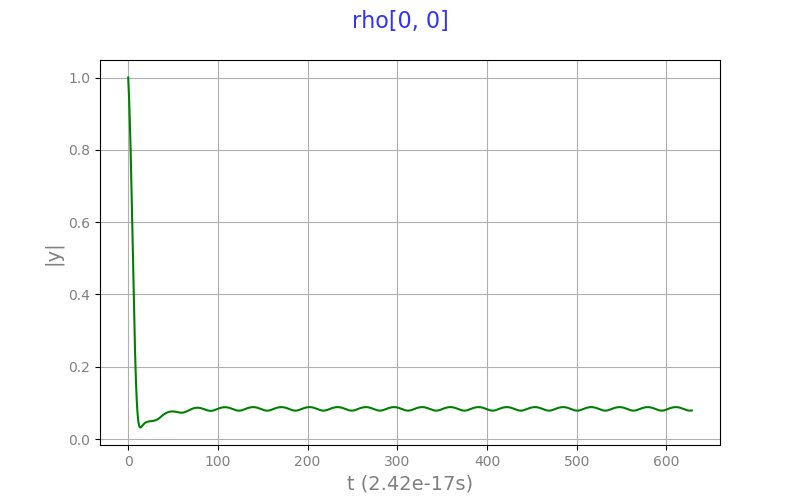

'Min. Density = 0.032075 at t = 13.613568'

In [19]:
# rho(0, 0)
plot_rhohat_block(0, 0, "min")

<IPython.core.display.Javascript object>


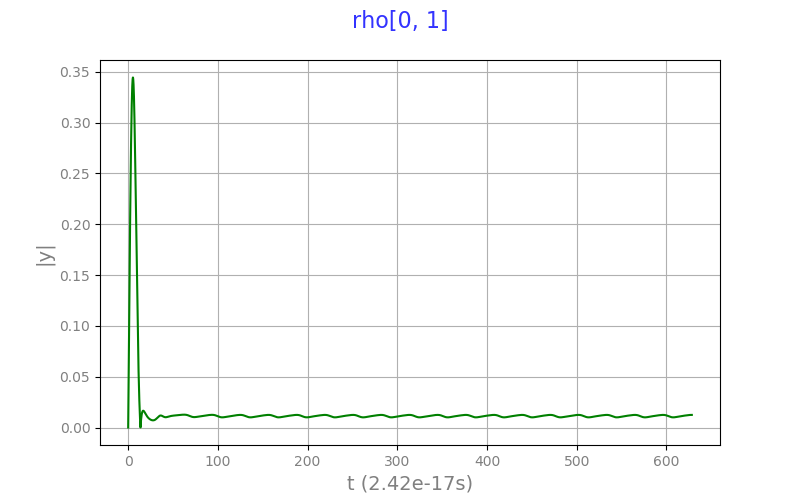

'Max. Density = 0.344328 at t = 5.298820'

In [20]:
plot_rhohat_block(0, 1)

<IPython.core.display.Javascript object>


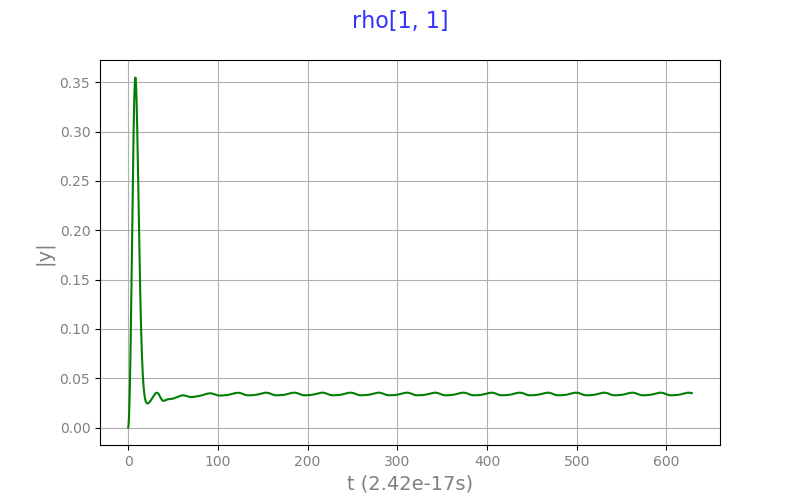

'Max. Density = 0.354909 at t = 8.021533'

In [21]:
plot_rhohat_block(1, 1)

<IPython.core.display.Javascript object>


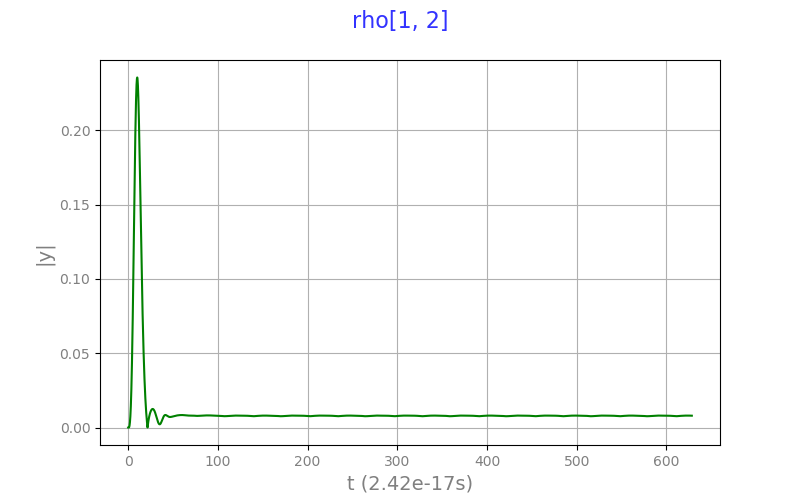

'Max. Density = 0.235528 at t = 10.053096'

In [22]:
plot_rhohat_block(1, 2)

<IPython.core.display.Javascript object>


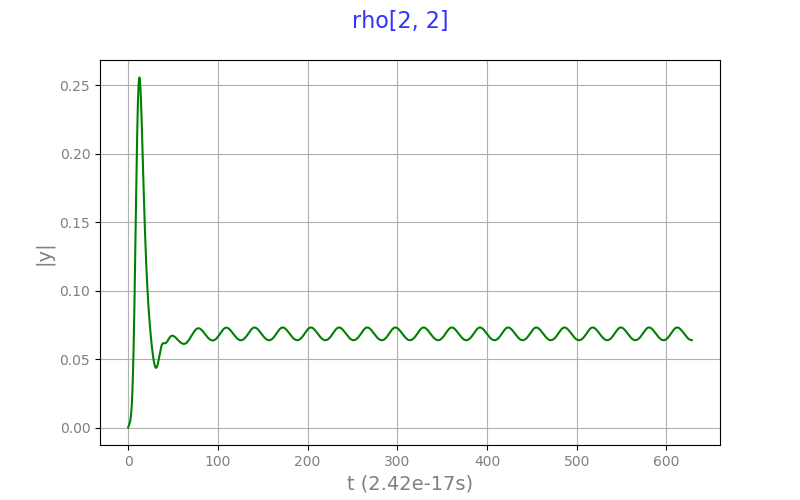

'Max. Density = 0.255572 at t = 12.503539'

In [23]:
plot_rhohat_block(2, 2)

In [24]:
# rho(N_H-1, N_H-1)
N_Mid = np.int64(np.floor(N_H / 2))

<IPython.core.display.Javascript object>


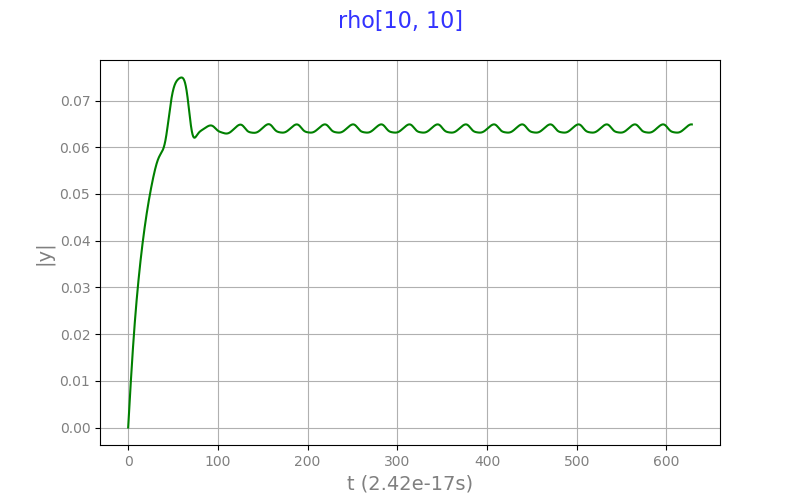

'Max. Density = 0.074945 at t = 59.376101'

In [25]:
plot_rhohat_block(N_Mid, N_Mid)

<IPython.core.display.Javascript object>


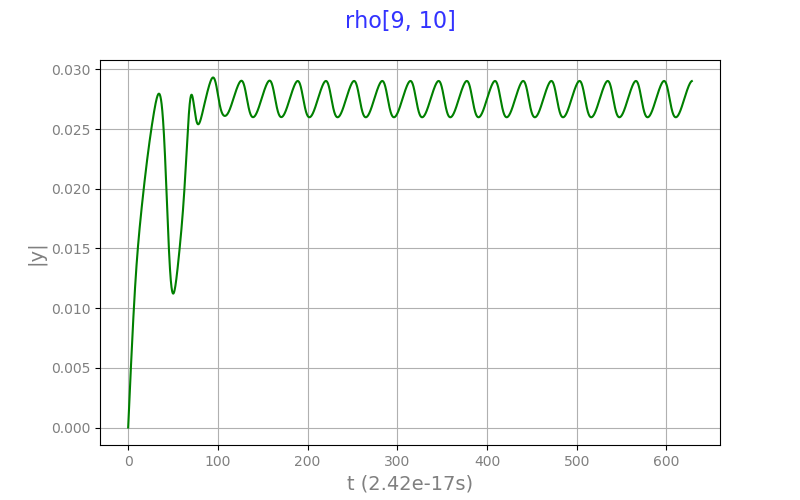

'Max. Density = 0.029318 at t = 94.645715'

In [26]:
plot_rhohat_block(N_Mid-1, N_Mid)

<IPython.core.display.Javascript object>


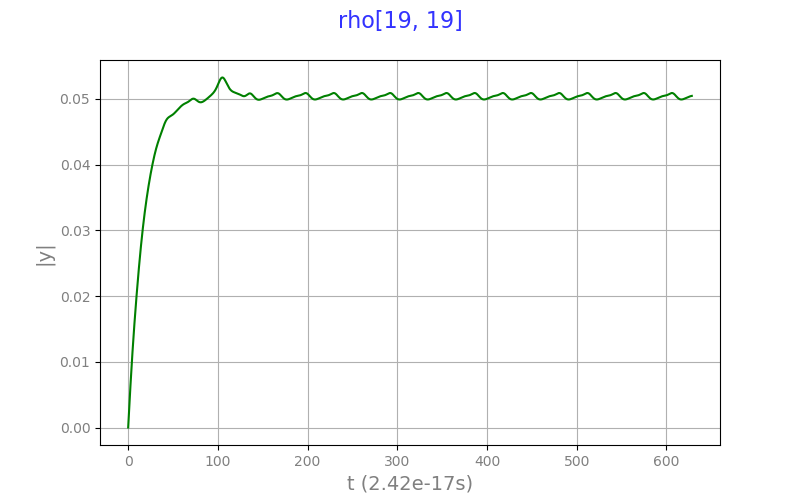

'Max. Density = 0.053267 at t = 105.033914'

In [27]:
plot_rhohat_block(N_H-1, N_H-1)

<IPython.core.display.Javascript object>


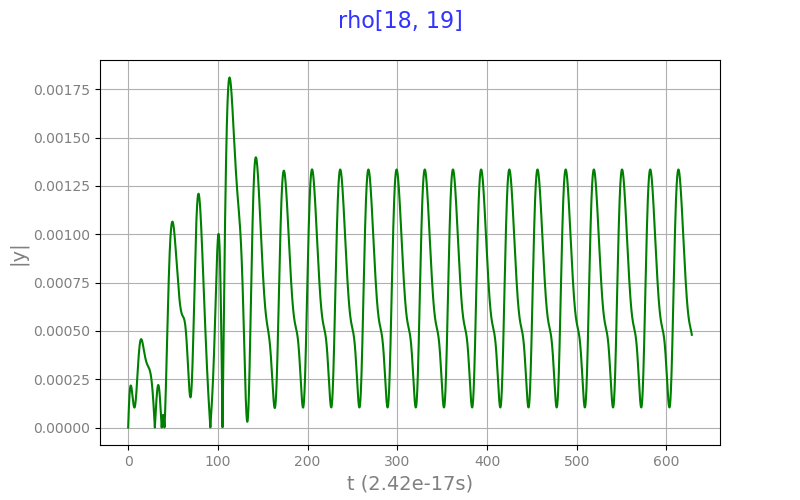

'Max. Density = 0.001811 at t = 112.992616'

In [28]:
plot_rhohat_block(N_H-2, N_H-1)

### Consistency Check

#### Trace


<IPython.core.display.Javascript object>


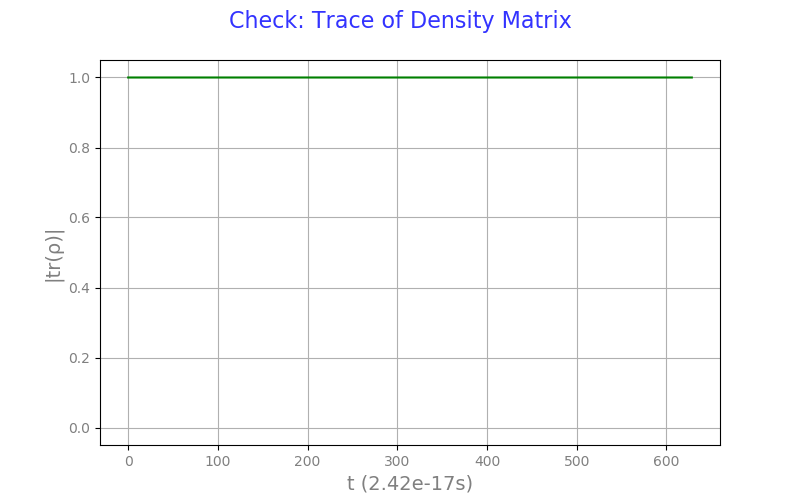

'Mean Error of the last 100 steps = -3.664e-16'

In [29]:
def tr_rhovec(rhovec):
    """ Compute Trace Over Time
    Args:
        rhovec: An (N_H^2 * pts) straightened density matrix
        
    Returns: An (T, 1) trace vector
    """
    
    # check dimensions
    NN, pts = np.shape(rhovec)
    N_H_raw = np.sqrt(NN)
    N_H = np.int64(N_H_raw)
    
    if abs(N_H_raw - N_H) > 1e-13:
        raise ValueError("[Error] Bad dimension of a straightened square matrix: " + str(NN))
    
    tr = np.zeros([1, pts], dtype='complex128')
    for i in range(N_H):
        tr += rhovec[i * (N_H+1), :]
        
    return np.absolute(tr)

def plot_tr_rhovec(rhovec):
    """ Check Trace Divergence """
    
    # initialize figure
    fig = plt.figure(figsize=(8, 5), dpi=100)  # No vector format, set manually
    ax = fig.add_subplot(111)
    
    # main plot
    t = t_lin
    y = tr_rhovec(rhovec).transpose()
    ax.plot(t, y, color="green", label="rho")
    
    # display settings
    # may add , marker="o", markersize=2
    # ax.plot(t, np.imag(y), color="green", label="im")
    ax.set_xlabel("t (2.42e-17s)", fontsize=14, color="#808080")
    ax.tick_params(axis="x", labelcolor="#808080")
    ax.set_ylabel("|tr(ρ)|", fontsize=14, color="#808080")
    ax.set_ylim([-0.05, 1.05])
    ax.tick_params(axis="y", labelcolor="#808080")
    ax.xaxis.get_offset_text().set_color("#808080")
    ax.yaxis.get_offset_text().set_color("#808080")
    ax.grid()
    #ax.legend()
    
    # title
    ttl = "Check: Trace of Density Matrix"
    fig.suptitle(ttl, fontsize=16, color="#3333ff")
    
    # show
    fig.show()
    
    # return
    return y
    
tr = plot_tr_rhovec(rhohat_vec)
display("Mean Error of the last 100 steps = {0:.3e}".format(np.mean(tr[-100:] - 1)))
